# Q8 Protein Structure Prediction

https://arxiv.org/pdf/1702.03865.pdf

Multiscale convolutional network with bidirectional GRU layer, trained on Nvidia GTX 970M.

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# display graphs within the notebook
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model, load_model
from keras import layers
from keras import optimizers
from keras import regularizers

# my script for loading files
import cullpdb_loader

Using TensorFlow backend.


## Constants and Hyperparameters
Declare constants about data such as the length of a protein and the number of possible residues and classes.
<br><br>
Declare hyperparameters about model such as learning rate, number of epochs of training (how many iterations through the entire data set to train for), etc.

In [2]:
NUM_RESIDUES = 700           # per protein (ie the length of each protein)
RESIDUE_SIZE = 22
NUM_CLASSES = 9              # 8 + 'NoSeq' -- output dimension
PSSM_SIZE = 22
NUM_FEATURES = RESIDUE_SIZE + PSSM_SIZE # size of one hot vector per residue

INPUT_SHAPE = (NUM_RESIDUES, NUM_FEATURES)
OUTPUT_SIZE = NUM_CLASSES

LEARNING_RATE = 0.01
# regularization factor
L2 = 0.025
EPOCHS = 60
MINIBATCH = 200
LOSS='categorical_crossentropy'
OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE)

SHOW_ACCURACY = True  # set to False for quicker train ops

SAVE_FILE = "models/q8pred.h5py"

DATA = "data/cullpdb+profile_6133.npy.gz"
DATA_FILTERED = "data/cullpdb+profile_6133_filtered.npy.gz"
DATA_TEST = "data/cb513+profile_split1.npy.gz"

## Load Data
<b>Data:</b><br> _x represents input proteins, _y represents target structure classifications (each as one-hot vectors) <br><br>
<b>Data Shape:</b><br> The first dimension represents the number of proteins (ie the size of the dataset), second the number of residues per protein (length of each protein), and third the size of residue or structure vector.<br> For example, train_x without pssm is shape (5600, 700, 22): it is an <b>m \* n \* p</b> matrix where there are <b>m</b> proteins (each row), <b>n</b> residues per protein (each column), and <b>p</b> sized vectors to represent a single residue or a single structure (each "slice").

In [3]:
train = cullpdb_loader.load_residues(DATA_FILTERED, split=False, two_d=True, pssm=True)  # load from my helper file

test = cullpdb_loader.load_cb513(DATA_TEST, two_d=True, pssm=True)

# train, validation, and test were loaded as tuples of (input, output);
train_x, train_y = train
test_x, test_y = test

#train_x, train_y = train_x[:10], train_y[:10]

Loading protein residues and labels...
Loading file from C:\SANJAY\CS\Projects\sdscbio\data\cullpdb+profile_6133_filtered.npy.gz...
File Loaded.
Loaded protein residues and labels.
Reshaping...
Reshaped
Loading file from C:\SANJAY\CS\Projects\sdscbio\data\cb513+profile_split1.npy.gz...
File Loaded.


In [4]:
# print a protein to see example representation (with character labels instead of one-hot vectors)
cullpdb_loader.print_residues(train_x[0], labels=train_y[0], two_d=True)

# print to verify data was loaded in correct shapes:
print("train_x:", train_x.shape)
print("train_y", train_y.shape)
print("test_x:", test_x.shape)
print("test_y:", test_y.shape)

Residues:
FDYQTVYFANQYGLRTIELGESEFVDNTLDNQHKXVIKAAWGGGYTNRNNVVINFKVDESLCDNLYFKDTDQPLVPXPASYYTLASDRIAIPKGQIXAGVEVQLTDDFFADEKSISENYVIPLLXTNVQGADSILQGKPVVENPVLTNAGDWSILPQNFVLYAVKYVNPWHGEYLRRGIDHATVAGTSKDIIRHEQFVENDEVVNISTKSXKDNLLTLKTKDESGKDISYTVRLSFAEDGSCTVHSGSQNVVVSGSGKFVSKGEKNSLGGKDRNAIYLDYTVNLTDNNIQLATKDTLVLRTRNVYGGKSLEVVRK-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Labels:
LLLLEEELSLSEEEEEEELSLLSSSLLHHHHTTEEEEEEEEESSSSLLSLEEEEEEELGGGGTTLEETTTLLBLEELLGGGEEESLSEEEELTTLSEEEEEEEELHHHHHSGGGGSSLEEEEEEEEEEESSSEELLLEESSSSLLTTLGGGEEELLLSEEEEEEEEELTTLEEEEEEEEEEEEETTEEEEEEELLSSGGGSEEEEEEESSSSEEEEEEEEELTTSLEEEEEEEEEELTTSEEEEEELSTTLEEEEEEEEEEEEETTLGGGSLEEEEEEEEE

### Custom Accuracy Metric

The default Keras accuracy metric does not compare observations and targets over multiple dimensions. A custom method to find  accuracy must be defined.
<br><br>
Here, a <b>mask</b> is created -- a matrix with ones where the target labels have labels that are not 'NoSeq', and zeros where the target labels are 'NoSeq'. We can then do a comparison between observed and target labels, and by multiplying the resulting boolean matrix by this mask, we ignore any right/wrong labels in the trailing 'NoSeq' region (that exists only to pad the protein to the correct length).
<br><br>
This gives an accuracy metric depending only on the non-'NoSeq' labels -- otherwise, the accuracy would be incorrectly inflated based on the easy-to-predict padding at the end.

In [5]:
# Second custom accuracy: ignore trailing noseq's
def custom_acc(true, obs):
    print("Using custom accuracy")
    if not SHOW_ACCURACY:
        return K.constant(float('NaN'))
        
    # convert one-hot vectors for residues to scalars
    true_vals = K.argmax(true, axis=2)
    obs_vals = K.argmax(obs, axis=2)
    
    # mask is 2D matrix with 1s in indices that are residues
    # and 0s in indices that are 'NoSeq'
    # subtract all 8's to shift 'NoSeq' values to zero
    mask = K.sign(K.abs(true_vals - 8*K.ones_like(true_vals, dtype='int64')))
    mask = K.cast(mask, dtype=K.floatx())
    # 1D vector with each index the number of non-'NoSeq' residues 
    # in corresponding protein
    length = K.sum(mask, axis=1)
    
    # compare observed and predicted values (cast from boolean to 1s and 0s),
    # then multiply by mask to nullify any trailing 'NoSeq' equalities
    comparison = K.cast(K.equal(true_vals, obs_vals), dtype=K.floatx())
    comparison = comparison * mask
    
    # and return average
    return K.sum(comparison) / K.sum(length)

### Learning Rate Scheduler
Decrease learning rate after certain number of epochs to make learning smoother.

In [6]:
def lr_sched(epoch):
    if epoch >= 30:
        return LEARNING_RATE / 10
    else:
        return LEARNING_RATE

### Block of convolutional and batch norm layers
See picture below for layout.

Each convolutional layer is a 1-dimensional convolution -- for each protein, each step of the convolution takes window-sized many residues, taking as input the entire feature slices of each of these residues. The output is a 700-length protein (obtained from 700 steps of the convolutional window, using padding on the sequence boundaries) with number of features per residue equal to the number of filters (the first parameter) of the layer.

In [7]:
def add_block(input_tensor):
    # 3 parallel convolutions -- see image below
    # Each has 32 filters (ie the output dimension) and window sizes of 3, 7, and 9
    # residues respectively.
    c1 = layers.convolutional.Conv1D(32, 3, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(input_tensor)
    c2 = layers.convolutional.Conv1D(32, 7, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(input_tensor)
    c3 = layers.convolutional.Conv1D(32, 9, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(input_tensor)
    
    # depth stack of 3 convolutions with batch norm
    merge1 = layers.concatenate([c1, c2, c3])
    merge1 = layers.normalization.BatchNormalization()(merge1)
    
    # final singe convolution with batch norm
    c4 = layers.convolutional.Conv1D(48, 9, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(merge1)
    c4 = layers.normalization.BatchNormalization()(c4)
    
    # 1-window conv on inputs
    c_skip = layers.convolutional.Conv1D(44, 1, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(input_tensor)
    c_skip = layers.normalization.BatchNormalization()(c_skip)
    
    # depth concat of last conv, middle conv, and skip connection
    merge2 = layers.concatenate([c4, merge1, c_skip])
    
    return merge2    

## Model Architecture
Replacing fully connected layers with convolutional layer, bidirectional recurrent layer, convolutional layer.
![](architecture.png)
The input tensor is concatenated to maintain original representation and hopefully improve baseline prediction.

In [8]:
input_tensor = layers.Input(shape=INPUT_SHAPE)

block1 = add_block(input_tensor)
#block1 = input_tensor

block2 = add_block(block1)

conv1 = layers.convolutional.Conv1D(64, 5, 
        activation='relu', padding='same',
        kernel_regularizer=regularizers.l2(L2))(block2)

with_input = layers.concatenate([conv1, input_tensor])

fbgru1 = layers.wrappers.Bidirectional(layers.recurrent.GRU(12, return_sequences=True))(with_input)

output = layers.convolutional.Conv1D(OUTPUT_SIZE, 1, 
        activation='softmax', padding='same', name="OutputLayer",
        kernel_regularizer=regularizers.l2(L2))(fbgru1)

model = Model(inputs=input_tensor, outputs=output)

### Compile the model given a loss function, optimizer, and learning rate (specified above)

In [9]:
# optimizer= takes either string or optimizer object
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[custom_acc])

Using custom accuracy


### Number of model parameters per layer and output dimensions from each layer

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 700, 44)       0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 700, 32)       4256                                         
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 700, 32)       9888                                         
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 700, 32)       12704                                        
___________________________________________________________________________________________

___
### Train the model on training data against target training labels, show accuracy on validation data each epoch
Here, the <b>val_loss</b> and <b>val_acc</b> are the loss and accuracy on the actual test data -- not a recommended practice but done here for the sake of reproducing previous results.

In [11]:
# Training
# verbose: 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
hist = model.fit(train_x, train_y, epochs=EPOCHS, shuffle=True, verbose=2,
                 batch_size=MINIBATCH, validation_data=(test_x, test_y),
                callbacks=[keras.callbacks.LearningRateScheduler(lr_sched)])
print("Done training")

Train on 5534 samples, validate on 514 samples
Epoch 1/60
84s - loss: 1.5615 - custom_acc: 0.3524 - val_loss: 0.8787 - val_custom_acc: 0.3066
Epoch 2/60
79s - loss: 1.0136 - custom_acc: 0.3772 - val_loss: 0.9357 - val_custom_acc: 0.3226
Epoch 3/60
80s - loss: 0.8071 - custom_acc: 0.4526 - val_loss: 0.9816 - val_custom_acc: 0.2257
Epoch 4/60
80s - loss: 0.7827 - custom_acc: 0.5047 - val_loss: 0.6719 - val_custom_acc: 0.2453
Epoch 5/60
81s - loss: 0.6861 - custom_acc: 0.5360 - val_loss: 0.6786 - val_custom_acc: 0.2224
Epoch 6/60
82s - loss: 0.6779 - custom_acc: 0.5568 - val_loss: 0.6884 - val_custom_acc: 0.2332
Epoch 7/60
85s - loss: 0.6497 - custom_acc: 0.5563 - val_loss: 0.6726 - val_custom_acc: 0.2671
Epoch 8/60
84s - loss: 0.6023 - custom_acc: 0.5764 - val_loss: 0.6358 - val_custom_acc: 0.2532
Epoch 9/60
83s - loss: 0.5489 - custom_acc: 0.5871 - val_loss: 0.5629 - val_custom_acc: 0.2773
Epoch 10/60
80s - loss: 0.5138 - custom_acc: 0.5906 - val_loss: 0.5660 - val_custom_acc: 0.2806
Ep

In [12]:
model.save(SAVE_FILE)
print("model saved.")

model saved.


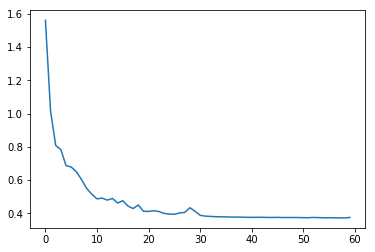

In [13]:
test_acc = list(hist.history.values())[2]
plt.plot(range(EPOCHS), test_acc)

___
## Test on cb513

In [ ]:
from keras.models import load_model
model = load_model(SAVE_FILE)

In [ ]:
test_acc = model.evaluate(test_x, test_y)
print(test_acc)

In [ ]:
i = 0
prediction = model.predict(test_x[i:i+1])
prediction = prediction.reshape(700, 9)
print("Shape:", prediction.shape)

In [ ]:
print("Expected:\n")
_ = cullpdb_loader.print_residues(test_x[i], labels=test_y[i], two_d=True)
print("\nPredicted:\n")
_ = cullpdb_loader.print_residues(test_x[i], labels=prediction, two_d=True)